In [1]:
import sys
sys.path.insert(1, '/home/nicolas/code/src')
sys.path.insert(1, '/home/nicolas/code/data')


import torch
import h5py
import matplotlib.pyplot as plt
import numpy as np
from RBM import GBRBM
device = torch.device("cuda")
dtype = torch.float

In [81]:
#fname="../model/AllParametersGBRBM_NGibbs_CLEAN_MNIST_50_Nh500_Ns10000_Nmb100_var_set_reg_1000_x1_lr_0.01.h5"
#fname="../model/AllParametersGBRBM_NGibbs_100_CLEAN_MNIST_Nh500_Ns10000_Nmb100_Nepoch10000_var_set_reg_1000_x1_lr_0.001.h5"
#fname="../model/AllParametersGBRBM_NGibbs_100_CLEAN_MNIST_Nh500_Ns10000_Nmb100_Nepoch10000_var_set_reg_100_x1_lr_0.01_fail.h5"
fname="../model/AllParametersGBRBM_NGibbs_100_CLEAN_MNIST_Nh500_Ns10000_Nmb100_Nepoch10000_var_set_reg_100_x1_lr_0.001_fail.h5"
f = h5py.File(fname,'r')
alltime = np.array(f['alltime'])
alltime = []
for t in f['alltime'][:]:
    if 'W_1'+str(t) in f:
        alltime.append(t)



alls = []
base = 1.7
v = np.array([0,1],dtype=int)
for k in range(30):
	v = np.append(v,int(base**k))
myRBM = GBRBM(num_visible=f['W_10'].shape[1],
                   num_hidden=100,
                   device=device,
                   lr_W1=0.01,
                   lr_W2=1e-4,
                   gibbs_steps=10,
                   UpdCentered=False,
                   mb_s=50,
                   num_pcd=50,
                   var_set = True)


317131 317131


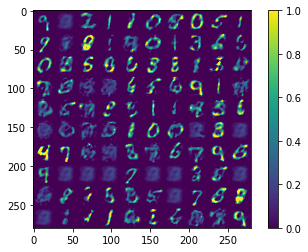

In [83]:
ffname = "../data/cleanMNIST10000.h5"
ff = h5py.File(ffname, 'r')
var_rm = ff['id_col']
data_mnist = ff['original']
X1 = torch.tensor(ff['clean'], device = device)
        
for t in np.array([317131]):
    at = np.abs(alltime-t)
    idx = np.argmin(at)
    t2 = alltime[idx]
    print(t, t2)
    #for nb_gibbs_gen in [50, 60, 70, 80, 90, 100, 500]:
    #print(nb_gibbs_gen)
    vinit = torch.normal(torch.zeros((myRBM.Nv,100), device=myRBM.device, dtype=myRBM.dtype))

    myRBM.W_1 = torch.tensor(f['W_1'+str(t2)], device = myRBM.device)
    myRBM.W_2 = torch.tensor(f['W_2'+str(t2)], device = myRBM.device)

    myRBM.vbias = torch.tensor(f['vbias'+str(t2)], device = myRBM.device)
    myRBM.hbias = torch.tensor(f['hbias'+str(t2)], device = myRBM.device)    
    si,mi,_,_ = myRBM.Sampling(vinit,it_mcmc=100)
    mi = (mi + torch.mean(X1,1).reshape(X1.shape[0],1))
    var = torch.std(X1,1)
    var[var<0.1] = 0.1
    mi = mi*var.reshape(X1.shape[0],1)




    rebuiltMNIST = torch.zeros(data_mnist.shape[0], mi.shape[1], device = device)
    passed = 0
    for i in range(data_mnist.shape[0]):
        if np.isin(i, var_rm):
            rebuiltMNIST[i, :] = torch.zeros(rebuiltMNIST[i, :].shape)
            passed +=1
        else :
            rebuiltMNIST[i, :] = mi[i-passed, :]
    X = rebuiltMNIST.T

    tile_X = []
    for c in range(10):
        L = torch.cat((tuple(X[i,:].reshape(28,28,1) for i in np.arange(c*10,(c+1)*10))))
        tile_X.append(L)
    tmp = torch.cat(tile_X,1)
    plt.imshow(tmp.cpu(), vmin=0, vmax = +1)
    plt.colorbar()
    plt.show()

In [69]:
fname_1 = "../model/AllParametersGBRBM_NGibbs_100_CLEAN_MNIST_Nh500_Ns10000_Nmb100_Nepoch10000_var_set_reg_1000_x1_lr_0.001.h5"
fname_2 = "../model/AllParametersGBRBM_NGibbs_100_CLEAN_MNIST_Nh500_Ns10000_Nmb100_Nepoch10000_var_set_reg_100_x1_lr_0.001_fail.h5"
time = np.array([317131])
f1 = h5py.File(fname_1,'r')
f2 = h5py.File(fname_2,'r')
W_1_solo = torch.tensor(f1['W_1'+str(317131)], device = device)
W_1_duo = torch.tensor(f2['W_1'+str(317131)], device = device)

In [70]:
_, S_1_solo, _ = torch.svd(W_1_solo)
_, S_1_duo, _ = torch.svd(W_1_duo)

[]

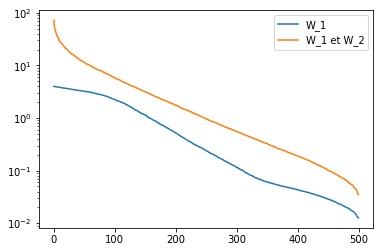

In [71]:
plt.plot(S_1_solo.cpu(), label = "W_1")
plt.plot(S_1_duo.cpu(), label="W_1 et W_2")
plt.legend()
plt.semilogy()

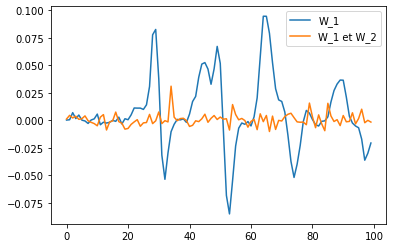

In [65]:
plt.plot(W_1_solo[0,:100].cpu(), label = "W_1")
plt.plot(W_1_duo[:100,0].cpu(), label="W_1 et W_2")
plt.legend()


In [66]:
W_1_solo.shape

torch.Size([500, 673])

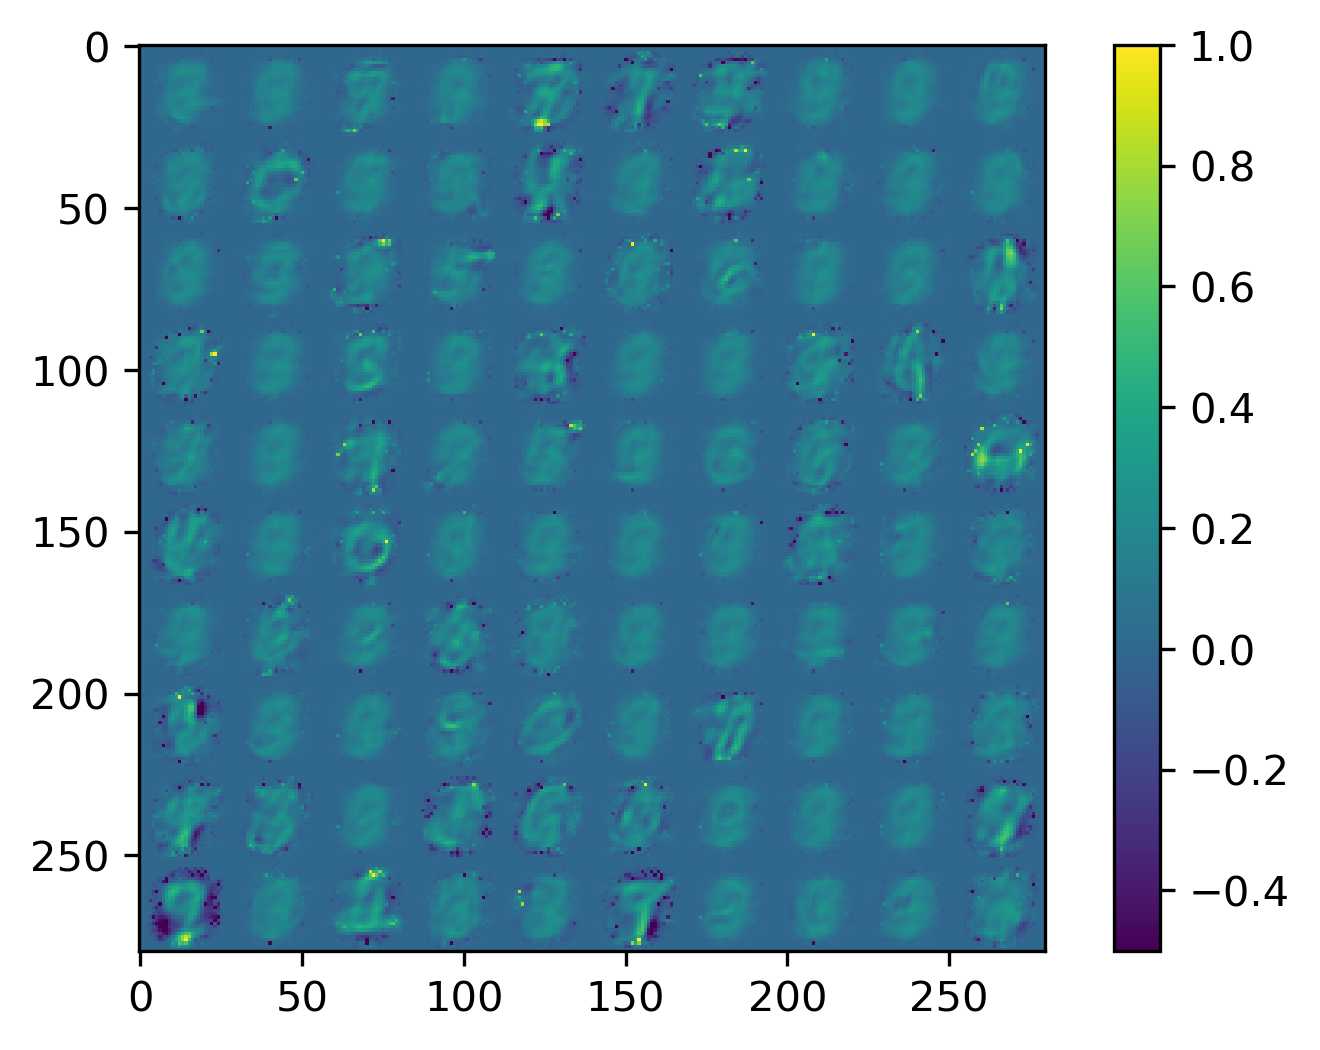

In [80]:
mi = W_1_duo[:100,:].T
mi = (mi + torch.mean(X1,1).reshape(X1.shape[0],1))
var = torch.std(X1,1)
var[var<0.1] = 0.1
mi = mi*var.reshape(X1.shape[0],1)
rebuiltMNIST = torch.zeros(data_mnist.shape[0], mi.shape[1], device = device)
passed = 0
for i in range(data_mnist.shape[0]):
    if np.isin(i, var_rm):
        rebuiltMNIST[i, :] = torch.zeros(rebuiltMNIST[i, :].shape)
        passed +=1
    else :
        rebuiltMNIST[i, :] = mi[i-passed, :]
X = rebuiltMNIST.T
plt.figure(dpi=300)
tile_X = []
for c in range(10):
    L = torch.cat((tuple(X[i,:].reshape(28,28,1) for i in np.arange(c*10,(c+1)*10))))
    tile_X.append(L)
tmp = torch.cat(tile_X,1)
plt.imshow(tmp.cpu(), vmin = -0.5, vmax = 1)
plt.colorbar()
plt.show()

In [129]:
time = 317131
fname="../model/AllParametersGBRBM_NGibbs_100_CLEAN_MNIST_Nh500_Ns10000_Nmb100_Nepoch10000_var_set_reg_100_x1_lr_0.001_fail.h5"
#fname="../model/AllParametersGBRBM_NGibbs_100_CLEAN_MNIST_Nh500_Ns10000_Nmb100_Nepoch10000_var_set_reg_1000_x1_lr_0.001.h5"
fname="../model/AllParametersGBRBM_NGibbs_CLEAN_MNIST_50_Nh500_Ns10000_Nmb100_var_set_reg_1000_x1_lr_0.01.h5"

f = h5py.File(fname, 'r')
alltime = np.array(f['alltime'])
alltime = []
for t in f['alltime'][:]:
    if 'W_1'+str(t) in f:
        alltime.append(t)



ffname = "../data/cleanMNIST10000.h5"
ff = h5py.File(ffname, 'r')
var_rm = ff['id_col']
data_mnist = ff['original']
X1 = torch.tensor(ff['clean'], device = device)
        
for t in np.array([317131]):
    at = np.abs(alltime-t)
    idx = np.argmin(at)
    t2 = alltime[idx]
    print(t, t2)
    vinit = torch.normal(torch.zeros((myRBM.Nv,10000), device=myRBM.device, dtype=myRBM.dtype))

    myRBM.W_1 = torch.tensor(f['W_1'+str(t2)], device = myRBM.device)
    myRBM.W_2 = torch.tensor(f['W_2'+str(t2)], device = myRBM.device)

    myRBM.vbias = torch.tensor(f['vbias'+str(t2)], device = myRBM.device)
    myRBM.hbias = torch.tensor(f['hbias'+str(t2)], device = myRBM.device)    
    si,mi,_,_ = myRBM.Sampling(vinit,it_mcmc=50)
    #si = (si + torch.mean(X1,1).reshape(X1.shape[0],1))
    #var = torch.std(X1,1)
    #var[var<0.1] = 0.1
    #si = si*var.reshape(X1.shape[0],1)




    rebuiltMNIST = torch.zeros(data_mnist.shape[0], mi.shape[1], device = device)
    passed = 0
    for i in range(data_mnist.shape[0]):
        if np.isin(i, var_rm):
            rebuiltMNIST[i, :] = torch.zeros(rebuiltMNIST[i, :].shape)
            passed +=1
        else :
            rebuiltMNIST[i, :] = mi[i-passed, :]
    #X = rebuiltMNIST.T
    X = si
sample_duo_bis = X

317131 223582


In [130]:
X1 = X1 - torch.mean(X1,1).reshape(X1.shape[0],1)
var = torch.std(X1,1)
var[var<0.1] = 0.1
X1 = X1/var.reshape(X1.shape[0],1)
_,S_solo,_ = torch.svd(sample_solo/np.sqrt(10000))
_,S_duo,_ = torch.svd(sample_duo/np.sqrt(10000))
_,S_duo_bis, _ = torch.svd(sample_duo_bis/np.sqrt(10000))
_,S_data,_ = torch.svd(torch.tensor(X1)/np.sqrt(10000))

<ipython-input-130-88ef5a2b4bea>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _,S_data,_ = torch.svd(torch.tensor(X1)/np.sqrt(10000))


[]

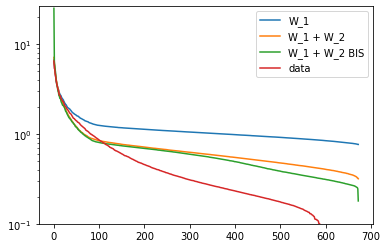

In [131]:
plt.plot(S_solo.cpu(), label = "W_1")
plt.plot(S_duo.cpu(), label = "W_1 + W_2")
plt.plot(S_duo_bis.cpu(), label = "W_1 + W_2 BIS")
plt.plot(S_data.cpu(), label = "data")
plt.legend()
plt.ylim(bottom = 0.1)
plt.semilogy()

In [145]:
W_1 = np.array(f['W_1'+str(alltime[-1])])
W_2 = np.array(f['W_2'+str(alltime[-1])])


[]

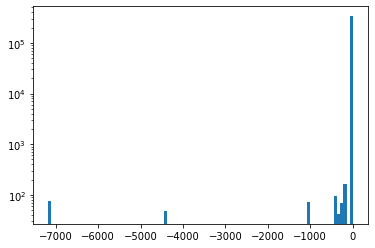

In [151]:
plt.hist(W_2.reshape(W_2.shape[0]*W_2.shape[1],1), bins = 100)
plt.semilogy()

[]

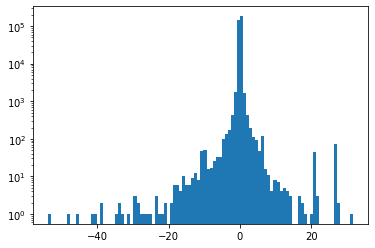

In [152]:
plt.hist(W_1.reshape(W_1.shape[0]*W_1.shape[1],1), bins = 100)
plt.semilogy()